In [1]:
import calculate_return as cr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from math import sqrt
import sharpe
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
plt.style.use('seaborn')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=13)  # fontsize of the figure title

In [211]:
# Fetching baseline data
ports = cr.fetch_returns('garch', range(10000))

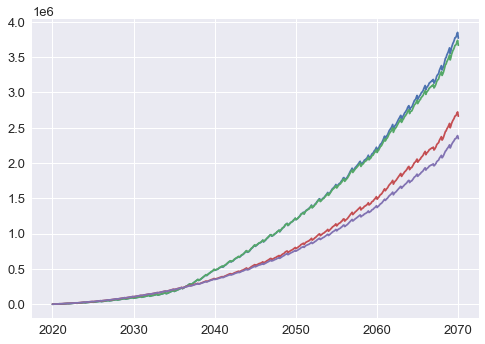

In [3]:
plt.plot(ports.groupby(level=1).mean().loc[:, ['dual_phase', 'single_phase', '100', '9050']])

In [3]:
sharpe_ratio = sharpe.calculate_sharpe(ports)

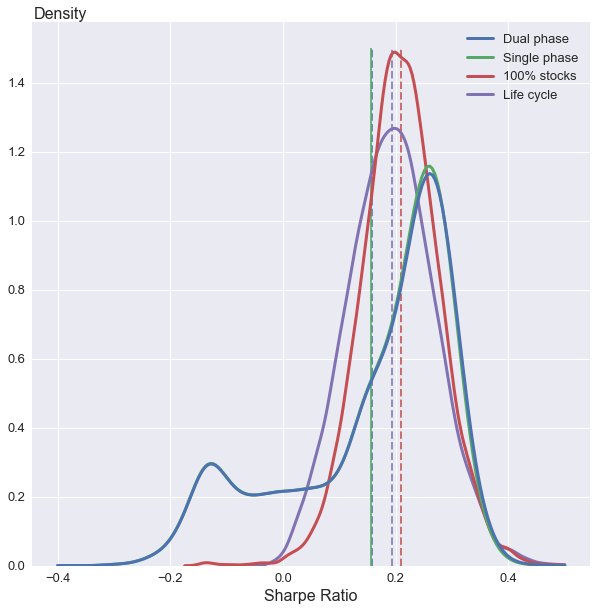

In [76]:
f, ax = plt.subplots(figsize=(10,10))
ax = sns.kdeplot(data = sharpe_ratio, linewidth = 3, clip= (-0.4, 0.5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_ylabel("Density", loc='top', rotation=0, labelpad=-80)
ax.set_xlabel("Sharpe Ratio")
for i, strategy in enumerate(['Dual phase', 'Single phase', '100% stocks', 'Life cycle']):
    if strategy == "Single phase":
        ax.vlines(sharpe_ratio[strategy].mean(), ymin= 0, ymax=1.5, color = cycle[i], linestyle="solid", alpha = 0.8, linewidth = 2)
    else:
        ax.vlines(sharpe_ratio[strategy].mean(), ymin= 0, ymax=1.5, color = cycle[i], linestyle="--", alpha = 0.8, linewidth = 2)
#f.savefig("Empirical/sharpe_distribution.png", bbox_inches = 'tight', pad_inches = 0.1)

In [9]:
sharpe.CE_ports(ports)

,dual_phase,single_phase,100,9050
Certainty Equivalent,"1,898,030.635446","1,988,516.720619","1,163,905.354848","1,584,289.854901"


In [91]:
ports.loc[(1, slice(None)), :].savings.cumsum().max()

832764

In [212]:
cum_savings = ports.loc[(1, slice(None)), :].savings.cumsum().max()

In [139]:
ports['100']/ports.loc[(slice(None), '2070-01-01'), '100'].groupby(level=0).mean()

random_state  period    
0             2020-01-01   0.001
              2020-02-01   0.001
              2020-03-01   0.002
              2020-04-01   0.003
              2020-05-01   0.004
                            ... 
399           2069-09-01   1.012
              2069-10-01   0.885
              2069-11-01   0.975
              2069-12-01   0.986
              2070-01-01   1.000
Name: 100, Length: 240400, dtype: float64

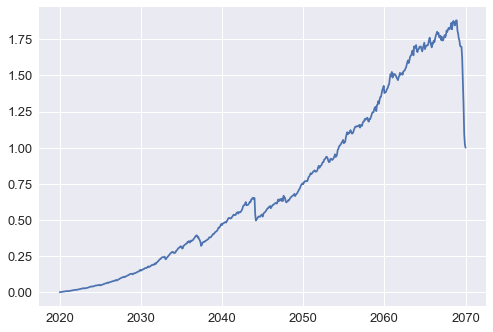

In [213]:
plt.plot((ports['100']/ports.loc[(slice(None), '2070-01-01'), '100'].groupby(level=0).mean()).groupby(level=1).mean())

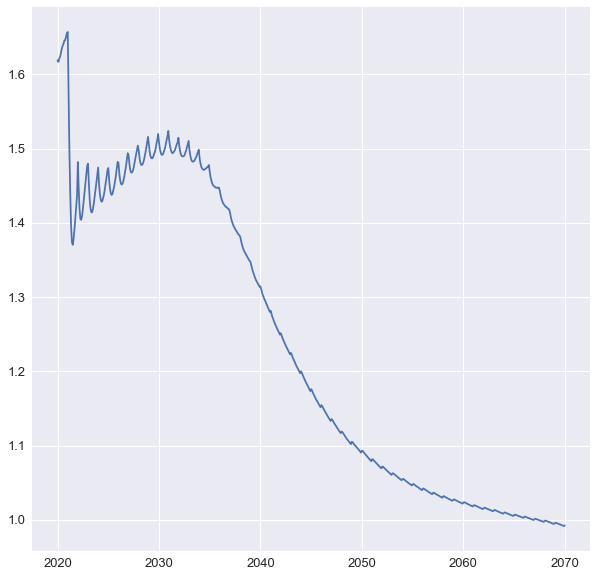

In [306]:
f, ax = plt.subplots(figsize=(10,10))
ax.plot((ports.pv_u/ports.pv_u.groupby(level=0).max()).groupby(level=1).mean()/(ports['100']/ports['100'].groupby(level=0).max()).groupby(level=1).mean())
#ax.plot((ports.pv_u/ports.pv_u.groupby(level=0).max()).groupby(level=1).mean())
#ax.plot((ports['100']/ports['100'].groupby(level=0).max()).groupby(level=1).mean())

In [234]:
limit = 250000

In [215]:
ports['end_pv_u'] = ports.groupby(level=0).take([-1])[['dual_phase']].reset_index(level=0, drop=True)

In [216]:
ports.end_pv_u = ports.end_pv_u.bfill()

In [217]:
ports['end_100'] = ports.groupby(level=0).take([-1])[['100']].reset_index(level=0, drop=True)

In [218]:
ports.end_100 = ports.end_100.bfill()

In [235]:
ports = ports[ports['end_pv_u'].abs() > limit]
ports = ports[ports['end_100'].abs() > limit]

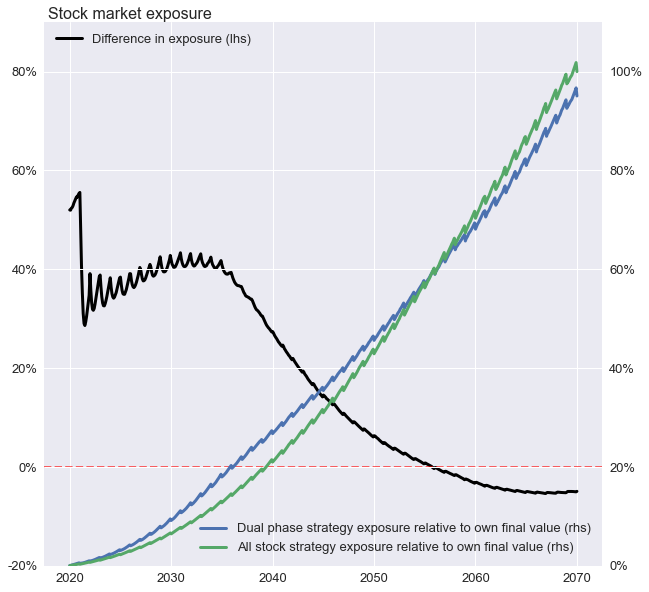

In [369]:
f, ax = plt.subplots(figsize=(10,10))
ax.plot((ports['pv_u']*100/ports['end_pv_u']).groupby(level=1).mean()/(ports['100']/ports['end_100']).groupby(level=1).mean()-100, color='black', linewidth = 3)
ax2 = ax.twinx()
ax2.plot((ports['pv_u']*100/ports['end_pv_u']).groupby(level=1).mean(), linewidth = 3)
ax2.plot((ports['100']*100/ports['end_100']).groupby(level=1).mean(), linewidth = 3)
ax.set_ylim(-20, 90)
ax2.set_ylim(0, 110)
ax.axhline(0, color = 'red', linestyle='dashed', linewidth=2, alpha = .6)
ax.set_ylabel("Stock market exposure", rotation=0, loc='top', labelpad=-205) 
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax2.legend(['Dual phase strategy exposure relative to own final value (rhs)', 'All stock strategy exposure relative to own final value (rhs)'], loc='lower right')
ax.legend(['Difference in exposure (lhs)'], loc='upper left')
f.savefig('Empirical/stock_market_exposure.png', bbox_inches = 'tight', pad_inches = 0.1)

In [244]:
df = ports
df['total_return_dual_phase'] = df.groupby(level=0, as_index=False).apply(lambda x: x.dual_phase/x.savings.cumsum()).reset_index(level=0, drop=True)


random_state
1       3.669
2      12.813
3       1.686
4       2.433
5       0.244
        ...  
9995    0.441
9996    0.277
9997    0.267
9998    3.093
9999    0.652
Name: total_return_dual_phase, Length: 9643, dtype: float64

In [261]:
df['total_return_100'] = df.groupby(level=0, as_index=False).apply(lambda x: x['100']/x.savings.cumsum()).reset_index(level=0, drop=True)

<AxesSubplot:xlabel='total_return_dual_phase', ylabel='Density'>

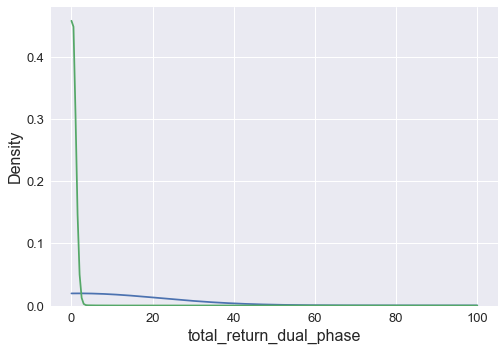

In [262]:
sns.kdeplot(data = df.total_return_dual_phase.groupby(level=0).pct_change().groupby(level=0).std()*sqrt(12), clip=(0, 100))
sns.kdeplot(data = df.total_return_100.groupby(level=0).pct_change().groupby(level=0).std()*sqrt(12), clip=(0, 100))

<AxesSubplot:xlabel='total_return_dual_phase', ylabel='Density'>

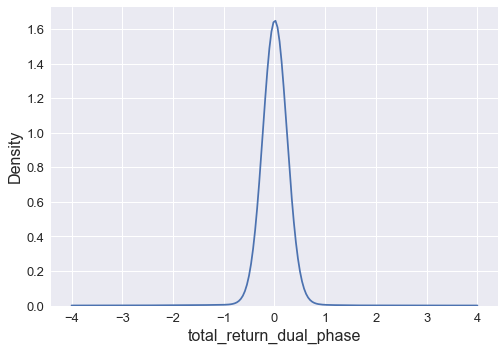

In [259]:
sns.kdeplot(data = df.total_return_dual_phase.groupby(level=0).pct_change().groupby(level=0).mean(), clip=(-4, 4))

In [247]:
(df.total_return_dual_phase.groupby(level=0).pct_change().groupby(level=0).std()*sqrt(12)).describe()

count    9643.000
mean        6.472
std       123.888
min         0.201
25%         0.317
50%         0.520
75%         1.865
max     10987.978
Name: total_return_dual_phase, dtype: float64

In [260]:
df.total_return_dual_phase.groupby(level=0).pct_change().groupby(level=0).mean()

random_state
1      -0.000
2      -0.157
3       0.005
4       0.045
5       0.007
        ...  
9995    0.012
9996    0.006
9997    0.005
9998    0.035
9999    0.005
Name: total_return_dual_phase, Length: 9643, dtype: float64